Another approach: 

* include the other 3 variables including the year, temp (shift to t+1), month_sin, month_cos
* Do the early stopping where the validation is minimum. 
* plot the residual 

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.python import keras
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
import tensorflow as tf
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

np.random.seed(7)

In [57]:
path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\geopy\france_cleaned"

df = pd.read_csv(path+'\\'+'Alsace.csv')
unlabelled_dataset = pd.read_excel('to_predict.xlsx')

In [58]:
def make_cyclic_sin(month):
    a = np.sin((month-1)*(2.*np.pi/12))
    return a
def make_cyclic_cos(month):
    b = np.cos((month-1)*(2.*np.pi/12))
    return b 

In [59]:
temp_df = df[df['PARAMETER'] == 'T2M']
temp_df = temp_df.drop('ANN', axis = 1)
#hum_df = data[data['PARAMETER'] == 'RH2M']

In [60]:
temp_df = temp_df.rename(columns = {'JAN':1, 'FEB':2,'MAR':3, 'APR':4, 'MAY':5,'JUN':6,
                         'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12})
temp_df = temp_df.drop(['PARAMETER','LAT','LON'], axis = 1)

In [61]:
temp_df.set_index('YEAR', inplace = True)
df = pd.concat([temp_df.stack()], axis=1)
df.reset_index(inplace = True)

In [62]:
df.rename(columns = {'level_1':'month',0:'avg_temp'}, inplace = True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 3 columns):
YEAR        468 non-null int64
month       468 non-null int64
avg_temp    468 non-null float64
dtypes: float64(1), int64(2)
memory usage: 11.1 KB


In [64]:
df.head(1)

,YEAR,month,avg_temp
0,1981,1,-2.68


In [65]:
# encoding for months 
#cyclic encoding from deep learning notebook
df['month_sin'] = df['month'].apply(lambda row: make_cyclic_sin(row))
df['month_cos'] = df['month'].apply(lambda row: make_cyclic_cos(row))

In [66]:
df.head()

,YEAR,month,avg_temp,month_sin,month_cos
0,1981,1,-2.68,0.000000,1.000000e+00
1,1981,2,-1.23,0.500000,8.660254e-01
2,1981,3,6.74,0.866025,5.000000e-01
3,1981,4,8.99,1.000000,6.123234e-17
4,1981,5,12.46,0.866025,-5.000000e-01


In [67]:
df['date'] = df[['YEAR','month']].astype(str).apply('-'.join, axis=1)

In [68]:
df.date = pd.to_datetime(df.date)
df = df.set_index('date')

In [69]:
df.shape

(468, 5)

In [70]:
df.tail()

,YEAR,month,avg_temp,month_sin,month_cos
date,,,,,
2019-08-01,2019,8,20.02,-0.500000,-8.660254e-01
2019-09-01,2019,9,15.32,-0.866025,-5.000000e-01
2019-10-01,2019,10,11.47,-1.000000,-1.836970e-16
2019-11-01,2019,11,4.60,-0.866025,5.000000e-01
2019-12-01,2019,12,2.99,-0.500000,8.660254e-01


In [71]:
unlabelled_dataset['date'] = unlabelled_dataset[['YEAR','month']].astype(str).apply('-'.join, axis=1)
unlabelled_dataset.date = pd.to_datetime(unlabelled_dataset.date)
unlabelled_dataset = unlabelled_dataset.set_index('date')

In [72]:
unlabelled_dataset.tail()

,YEAR,month,month_sin,month_cos
date,,,,
2021-08-01,2021,8,-0.500000,-8.660254e-01
2021-09-01,2021,9,-0.866025,-5.000000e-01
2021-10-01,2021,10,-1.000000,-1.836970e-16
2021-11-01,2021,11,-0.866025,5.000000e-01
2021-12-01,2021,12,-0.500000,8.660254e-01


In [73]:
unlabelled_dataset.shape

(24, 4)

In [74]:
combined_data = pd.concat([df,unlabelled_dataset])

In [75]:
combined_data.tail()

,YEAR,avg_temp,month,month_cos,month_sin
date,,,,,
2021-08-01,2021,NaN,8,-8.660254e-01,-0.500000
2021-09-01,2021,NaN,9,-5.000000e-01,-0.866025
2021-10-01,2021,NaN,10,-1.836970e-16,-1.000000
2021-11-01,2021,NaN,11,5.000000e-01,-0.866025
2021-12-01,2021,NaN,12,8.660254e-01,-0.500000


In [76]:
labelled = combined_data[:468]
unlabelled = combined_data[468:] ## this will be the x_test ( the model that has not seen yet)

In [77]:
# shifting the avg_temp to t+1 
labelled['avg_temp'] = df['avg_temp'].shift(1)

In [78]:
labelled.head(12)

,YEAR,avg_temp,month,month_cos,month_sin
date,,,,,
1981-01-01,1981,NaN,1,1.000000e+00,0.000000e+00
1981-02-01,1981,-2.68,2,8.660254e-01,5.000000e-01
1981-03-01,1981,-1.23,3,5.000000e-01,8.660254e-01
1981-04-01,1981,6.74,4,6.123234e-17,1.000000e+00
1981-05-01,1981,8.99,5,-5.000000e-01,8.660254e-01
1981-06-01,1981,12.46,6,-8.660254e-01,5.000000e-01
1981-07-01,1981,15.47,7,-1.000000e+00,1.224647e-16
1981-08-01,1981,16.75,8,-8.660254e-01,-5.000000e-01
1981-09-01,1981,17.32,9,-5.000000e-01,-8.660254e-01


In [79]:
df = df[1:] # the labelled data

In [80]:
# include the other 3 variables including the year, temp (shift to t+1), month_sin, month_cos

y = df.avg_temp
X = df.drop('month', axis = 1) # shift temp and include in x dont drop it
valid_and_test_size = 0.1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_and_test_size*2, random_state=42, shuffle=False)

In [81]:
display(X_train.head())
print(X_train.shape)

,YEAR,avg_temp,month_sin,month_cos
date,,,,
1981-02-01,1981,-1.23,0.500000,8.660254e-01
1981-03-01,1981,6.74,0.866025,5.000000e-01
1981-04-01,1981,8.99,1.000000,6.123234e-17
1981-05-01,1981,12.46,0.866025,-5.000000e-01
1981-06-01,1981,15.47,0.500000,-8.660254e-01


(373, 4)


In [82]:
display(X_valid.tail())
print(X_valid.shape)

,YEAR,avg_temp,month_sin,month_cos
date,,,,
2019-08-01,2019,20.02,-0.500000,-8.660254e-01
2019-09-01,2019,15.32,-0.866025,-5.000000e-01
2019-10-01,2019,11.47,-1.000000,-1.836970e-16
2019-11-01,2019,4.60,-0.866025,5.000000e-01
2019-12-01,2019,2.99,-0.500000,8.660254e-01


(94, 4)


In [83]:
y_train.shape

(373,)

In [84]:
X_valid.shape

(94, 4)

In [85]:
y_valid.shape

(94,)

In [86]:
# from series convert to array
y_train = y_train.values.reshape(len(y_train),1)
#y_test = y_test.values.reshape(len(y_test),1)
y_valid = y_valid.values.reshape(len(y_valid),1)

In [87]:
# normalize using minmax scaler
scaler = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train[['YEAR','avg_temp','month_cos','month_sin']] = scaler.fit_transform(X_train)
#X_test[['YEAR','month_sin','month_cos']] = scaler.fit_transform(X_test)
X_valid[['YEAR','avg_temp','month_cos','month_sin']] = scaler.fit_transform(X_valid)
y_train = scaler_y.fit_transform(y_train)
#y_test = scaler.fit_transform(y_test)
y_valid = scaler_y.fit_transform(y_valid)

In [89]:
X_train.head()

,YEAR,avg_temp,month_sin,month_cos
date,,,,
1981-02-01,0.0,0.173813,0.933013,0.750000
1981-03-01,0.0,0.434697,0.750000,0.933013
1981-04-01,0.0,0.508347,0.500000,1.000000
1981-05-01,0.0,0.621931,0.250000,0.933013
1981-06-01,0.0,0.720458,0.066987,0.750000


In [90]:
y_train.shape

(373, 1)

In [91]:
X_valid.shape

(94, 4)

In [92]:
y_valid.shape

(94, 1)

In [93]:
look_back=12
FORECAST_DISTANCE=1 # forecast on the next month
n_features = len(X_train.columns)


In [94]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

In [95]:
segmenter = SegmentXYForecast(width=look_back, step=1, y_func=last, forecast=FORECAST_DISTANCE) 

In [96]:
# the segmenter will segment the data according to the parameters set.
X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train.values],[y_train.flatten()])
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid.values],[y_valid.flatten()])
#X_test_rolled,  y_test_rolled,_ = segmenter.fit_transform([X_test.values],[y_test.flatten()]) # 2016-02-01 -> 2019-12-01

In [97]:
X_train_rolled.shape

(361, 12, 4)

In [98]:
y_train_rolled.shape

(361,)

In [99]:
X_valid_rolled.shape

(82, 12, 4)

In [100]:
y_valid_rolled.shape

(82,)

In [101]:
#####

In [105]:
BATCH_SIZE = 5
EPOCHS = 30
DROPOUT_RATE= 0.01
LSTM_UNIT_SIZE = 5

# Build the model 
model = Sequential()
model.add(LSTM(LSTM_UNIT_SIZE, activation = 'relu',input_shape = (look_back, n_features)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1))


#compile the model
#opt = Adam(lr=0.01, clipnorm=1.0)
#model.compile(loss='mean_squared_error', optimizer=opt)
model.compile(optimizer = 'adam', loss = 'mse')

# fit the model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
mc = ModelCheckpoint('best_model_mult.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
                    
history = model.fit(X_train_rolled, y_train_rolled, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_valid_rolled,y_valid_rolled), callbacks = [es,mc]) #, callbacks = es

Train on 361 samples, validate on 82 samples
Epoch 1/30
361/361 [==============================] - 1s 2ms/step - loss: 0.1481 - val_loss: 0.0732

Epoch 00001: val_loss improved from inf to 0.07320, saving model to best_model_mult.h5
Epoch 2/30
361/361 [==============================] - 0s 1ms/step - loss: 0.0449 - val_loss: 0.0506

Epoch 00002: val_loss improved from 0.07320 to 0.05062, saving model to best_model_mult.h5
Epoch 3/30
361/361 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0373

Epoch 00003: val_loss improved from 0.05062 to 0.03726, saving model to best_model_mult.h5
Epoch 4/30
361/361 [==============================] - 0s 1ms/step - loss: 0.0207 - val_loss: 0.0282

Epoch 00004: val_loss improved from 0.03726 to 0.02820, saving model to best_model_mult.h5
Epoch 5/30
361/361 [==============================] - 0s 1ms/step - loss: 0.0168 - val_loss: 0.0208

Epoch 00005: val_loss improved from 0.02820 to 0.02080, saving model to best_model_mult.h5

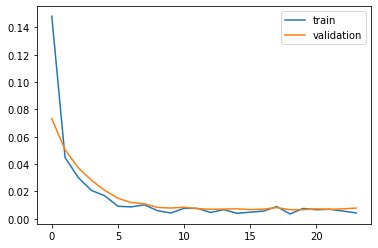

In [106]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [107]:
#from sklearn.metrics import mean_squared_error
#from math import sqrt


# WHAT IS HAPPENING HERE?
#def evaluate_model(model, X_valid, y_valid_true):
#    predictions = model.predict(X_valid)
#    rms = sqrt(mean_squared_error(y_valid_true, predictions))
#    print(rms)
#    normalized_rms = scaler.inverse_transform(np.array(rms).reshape(1,-1))[0][0]
#    return print("Root mean squared error on valid inverse transformed from normalization:",normalized_rms)


In [108]:
train_predict = model.predict(X_train_rolled) 

In [109]:
train_predict_inverse = scaler.inverse_transform(train_predict)

ValueError: non-broadcastable output operand with shape (361,1) doesn't match the broadcast shape (361,4)

In [524]:
train_predict = model.predict(X_train_rolled) # predict the train data 
test_predict_valid = model.predict(X_valid_rolled)

train_predict_orig = scaler.inverse_transform(train_predict) # to get the true value
test_predict_valid_origina = scaler.inverse_transform(test_predict_valid) # to get the true value
#test_predict = scaler.inverse_transform(test_predict) # this is the actual X_test

y_train = scaler.inverse_transform([y_train_rolled]) # to get the true value
y_valid = scaler.inverse_transform([y_valid_rolled]) # to get the true value
#y_test = scaler.inverse_transform([y_test_rolled])

In [525]:
train_predict.shape

(362, 1)

In [526]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict_orig[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict_orig[:,0])))
print('valid Mean Absolute Error:', mean_absolute_error(y_valid[0], test_predict_valid_origina[:,0]))
print('valid Root Mean Squared Error:',np.sqrt(mean_squared_error(y_valid[0], test_predict_valid_origina[:,0])))
print('\n')
#print('The data the model has not yet seen: ')
#print('test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
#print('test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 1.1366350943791632
Train Root Mean Squared Error: 1.4492035054201058
valid Mean Absolute Error: 1.7851629021691113
valid Root Mean Squared Error: 2.1593581756733373




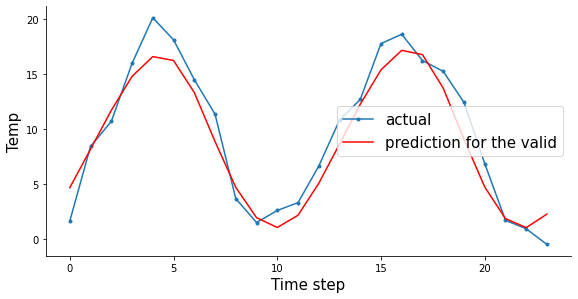

In [532]:
# validation

import seaborn as sns

aa=[x for x in range(24)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_valid[0][:24], marker='.', label="actual") 
plt.plot(aa, test_predict_valid_origina[:,0][:24], 'r', label="prediction for the valid")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

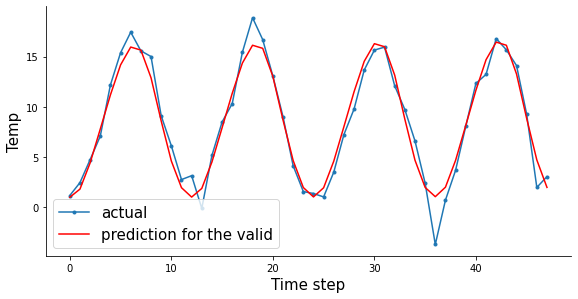

In [529]:

# training

import seaborn as sns

aa=[x for x in range(48)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_train[0][:48], marker='.', label="actual") 
plt.plot(aa, train_predict_orig[:,0][:48], 'r', label="prediction for the valid")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();